In [1]:
%%html
<style>
  table {margin-left: 0 !important;}
</style>

# Projeto Final: Detecção de rostos com uso de máscara de proteção para COVID-19

## Trabalho em Grupo
- **Curso:** FGV MBA - Business Analytics e Big Data
- **Disciplina:** Desafios e Requisitos dos Projetos Analíticos
- **Professor:** Bruno Brito de Souza
- **Projeto final:** Detecção de rostos com uso de máscara de proteção

## Integrantes
|Github|Kaggle|Nome|Matricula|E-mail|
|---|---|---|---|---|
|<a href="https://github.com/DanielFCampos"><img src="https://avatars2.githubusercontent.com/u/31582602?s=460&v=4" title="DanielFCampos" width="40" height="40"></a>|<a href="https://www.kaggle.com/danielferrazcampos"><img src="https://storage.googleapis.com/kaggle-avatars/images/3508055-kg.png" title="DanielFCampos" width="40" height="40"></a>|Daniel Campos|A57635769|[daniel.ferraz.campos@gmail.com](daniel.ferraz.campos@gmail.com)|
|<a href="https://github.com/ldaniel"><img src="https://avatars2.githubusercontent.com/u/205534?s=460&v=4" title="ldaniel" width="40" height="40"></a>|<a href="https://www.kaggle.com/leandrodaniel"><img src="https://storage.googleapis.com/kaggle-avatars/images/3415144-gr.jpg" title="ldaniel" width="40" height="40"></a>|Leandro Daniel|A57622988|[contato@leandrodaniel.com](contato@leandrodaniel.com)|
|<a href="https://github.com/ricardobreis"><img src="https://avatars2.githubusercontent.com/u/4885152?s=460&u=470b0bcc829715fd3944d921fec99ad0ea2d6263&v=4" title="ricardobreis" width="40" height="40"></a>|<a href="https://www.kaggle.com/ricardobreis"><img src="https://storage.googleapis.com/kaggle-avatars/images/3201976-kg.jpg" title="ricardobreis" width="40" height="40"></a>|Ricardo Reis|A57590919|[ricardo.l.b.reis@gmail.com](ricardo.l.b.reis@gmail.com)|
|<a href="https://github.com/RodriGonca"><img src="https://avatars2.githubusercontent.com/u/50252438?s=460&v=4" title="RodriGonca" width="40" height="40"></a>|<a href="https://www.kaggle.com/rodrigonca"><img src="https://storage.googleapis.com/kaggle-avatars/images/3511253-kg.png" title="RodriGonca" width="40" height="40"></a>|Rodrigo Gonçalves|A57566093|[rodrigo.goncalves@me.com](rodrigo.goncalves@me.com)|
|<a href="https://github.com/ygorlima1"><img src="https://avatars2.githubusercontent.com/u/52429828?s=460&v=4" title="ygorlima1" width="40" height="40"></a>|<a href="https://www.kaggle.com/ygorlima1"><img src="https://storage.googleapis.com/kaggle-avatars/images/3427786-kg.jpg" title="ygorlima1" width="40" height="40"></a>|Ygor Lima|A57549661|[ygor_redesocial@hotmail.com](ygor_redesocial@hotmail.com)|

## Libraries Utilizadas para Desenvolvimento da Análise

In [2]:
!pip3 install cairosvg

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
import os
import numpy as np
import pandas as pd
import random

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

import cv2 as cv
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report

from IPython.display import Markdown as md

In [4]:
seed = 42

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

## Data Preparation

In [5]:
image_size = 256
labels = ['without_mask', 'with_mask']

def get_data(data_dir):
        
    images = []
    
# cria uma lista com o index de cada label com base no nome da raíz do diretório informado.
    for label in labels:
        dir = os.path.join(data_dir, label)
        class_num = labels.index(label)
        
# percorre todas as imagens presentes no diretório, converte para grey_sacale e faz o resizing das imagens.
        for image in os.listdir(dir):    
            image_read = cv.imread(os.path.join(dir,image), cv.IMREAD_GRAYSCALE)
            image_resized = cv.resize(image_read, (image_size, image_size))
            images.append([image_resized, class_num])

    return np.array(images)

load_full_dataset = get_data('/kaggle/input/realworldfacemaskimages/real_world_covid_mask_images/')

In [6]:
mask_count = np.count_nonzero(load_full_dataset[:,1] == 1)
no_mask_count = np.count_nonzero(load_full_dataset[:,1] == 0)

print('Dataset original\n\n', len(load_full_dataset),
      'imagens no dataset com o tamanho', load_full_dataset[1,0].shape,
      '\n\nProporção',
      '\nSem máscara:\t', no_mask_count,
      '\nCom máscara:\t', mask_count)

Dataset original

 92671 imagens no dataset com o tamanho (256, 256) 

Proporção 
Sem máscara:	 90468 
Com máscara:	 2203


In [7]:
mask_dataset = load_full_dataset[load_full_dataset[:,1]==1]
no_mask_dataset = load_full_dataset[load_full_dataset[:,1]==0]

random_positions = np.random.choice(no_mask_count, replace=False, size=mask_count)

shuffled_no_mask_dataset = no_mask_dataset[random_positions,]

# New loaded set (balanced) with shuffled no-mask dataset
load_full_dataset = np.concatenate((mask_dataset, shuffled_no_mask_dataset))

In [8]:
mask_count = np.count_nonzero(load_full_dataset[:,1] == 1)
no_mask_count = np.count_nonzero(load_full_dataset[:,1] == 0)

print('Dataset rebalanceado (com seleção aleatória da variável majoritária)\n\n', len(load_full_dataset),
      'imagens no dataset com o tamanho', load_full_dataset[1,0].shape,
      '\n\nProporção',
      '\nSem máscara:\t', no_mask_count,
      '\nCom máscara:\t', mask_count)

Dataset rebalanceado (com seleção aleatória da variável majoritária)

 4406 imagens no dataset com o tamanho (256, 256) 

Proporção 
Sem máscara:	 2203 
Com máscara:	 2203


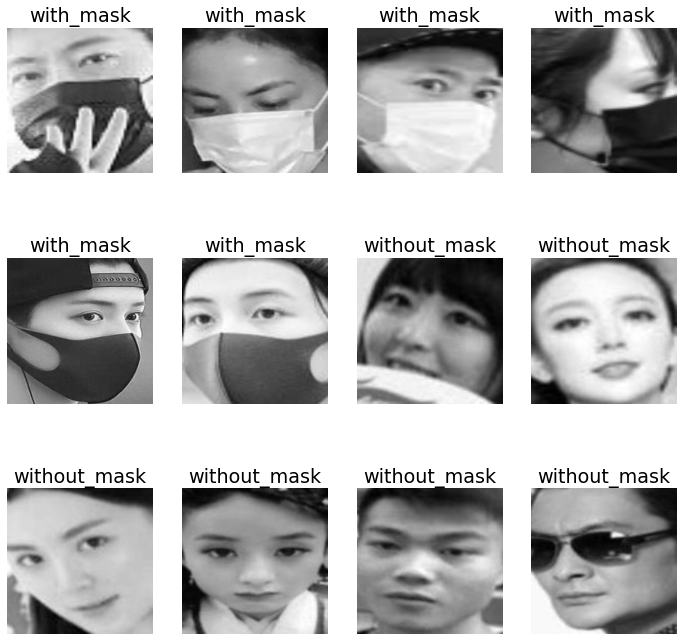

In [9]:
plt.rcParams.update({'font.size': 16})

fig = plt.figure(figsize = (12, 12))
columns = 4
rows = 3

randomlist = []

for i in range(0, int((columns * rows)/2)):
    n = np.random.randint(0, np.count_nonzero(load_full_dataset[:,1] == 0))
    randomlist.append(n)
    
for i in range(0, int((columns * rows)/2)):
    n = np.random.randint(np.count_nonzero(load_full_dataset[:,1] == 0), len(load_full_dataset))
    randomlist.append(n)
    
for i in range(1, columns * rows + 1):
    rnd = np.random.randint(0, len(load_full_dataset))
    img = load_full_dataset[randomlist[i-1]][0]  
    fig.add_subplot(rows, columns, i)
    plt.title(labels[load_full_dataset[randomlist[i-1]][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')

plt.show()

In [10]:
x_features = []
y_labels = []

for feature, label in load_full_dataset:
    x_features.append(feature)
    y_labels.append(label)
    
del load_full_dataset

In [11]:
x_features = np.array(x_features).reshape(-1, image_size, image_size, 1)
y_labels = np.array(y_labels)
y_labels = np.expand_dims(y_labels, axis =1)

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x_features, 
                                                    y_labels,
                                                    stratify = y_labels,
                                                    test_size = 0.2, 
                                                    random_state = 2)

del x_features, y_labels

In [13]:
print('\nTensor de features de treinamento:\t', x_train.shape, 
      '\nImagens:\t', len(x_train), 
      '\nSem máscara:\t', np.count_nonzero(y_train == 0), 
      '\nCom máscara:\t', np.count_nonzero(y_train == 1))

print('\nTensor de labels de treinamento:\t', y_train.shape, 
      '\nQuantidade:\t', len(y_train),
      '\nSem máscara:\t', np.count_nonzero(y_train == 0), 
      '\nCom máscara:\t', np.count_nonzero(y_train == 1))

print('\nTensor de features de teste:\t\t', x_test.shape, 
      '\nImagens:\t', len(x_test),
      '\nSem máscara:\t', np.count_nonzero(y_test == 0), 
      '\nCom máscara:\t', np.count_nonzero(y_test == 1))

print('\nTensor de labels de teste:\t\t', y_test.shape, 
      '\nQuantidade:\t', len(y_test),
      '\nSem máscara:\t', np.count_nonzero(y_test == 0), 
      '\nCom máscara:\t', np.count_nonzero(y_test == 1))


Tensor de features de treinamento:	 (3524, 256, 256, 1) 
Imagens:	 3524 
Sem máscara:	 1762 
Com máscara:	 1762

Tensor de labels de treinamento:	 (3524, 1) 
Quantidade:	 3524 
Sem máscara:	 1762 
Com máscara:	 1762

Tensor de features de teste:		 (882, 256, 256, 1) 
Imagens:	 882 
Sem máscara:	 441 
Com máscara:	 441

Tensor de labels de teste:		 (882, 1) 
Quantidade:	 882 
Sem máscara:	 441 
Com máscara:	 441


In [14]:
x_train = x_train / 255
x_test  = x_test  / 255

## Definição da Arquitetura da Rede Neural

In [15]:
i = Input(x_train.shape[1:])

a = Flatten()(i)

a = Dense(512, activation = 'relu')(a)
a = Dropout(0.4)(a)

a = Dense(512, activation = 'relu')(a)
a = Dropout(0.3)(a)

a = Dense(512, activation = 'relu')(a)
a = Dropout(0.1)(a)

a = Dense(1, activation = 'sigmoid')(a)

model_NN = Model(i,a)

In [16]:
i = Input(x_train.shape[1:])

b = Conv2D(32, (3,3), activation ='relu', padding = 'same')(i)
b = BatchNormalization()(b)
b = Conv2D(32, (3,3), activation ='relu', padding = 'same')(b)
b = BatchNormalization()(b)
b = MaxPooling2D(2,2)(b)

b = Conv2D(64, (3,3), activation ='relu', padding = 'same')(b)
b = BatchNormalization()(b)
b = Conv2D(64, (3,3), activation ='relu', padding = 'same')(b)
b = BatchNormalization()(b)
b = MaxPooling2D(2,2)(b)

b = Conv2D(128, (3,3), activation ='relu', padding = 'same')(b)
b = BatchNormalization()(b)
b = Conv2D(128, (3,3), activation ='relu', padding = 'same')(b)
b = BatchNormalization()(b)
b = MaxPooling2D(2,2)(b)

b = Conv2D(256, (3,3), activation ='relu', padding = 'same')(b)
b = BatchNormalization()(b)
b = Conv2D(256, (3,3), activation ='relu', padding = 'same')(b)
b = BatchNormalization()(b)
b = MaxPooling2D(2,2)(b)

b = Flatten()(b)

b = Dense(512, activation = 'relu')(b)
b = Dropout(0.4)(b)

b = Dense(512, activation = 'relu')(b)
b = Dropout(0.3)(b)

b = Dense(512, activation = 'relu')(b)
b = Dropout(0.1)(b)

b = Dense(1, activation = 'sigmoid')(b)

model_CNN = Model(i, b)

## Compilando e Visualizando a Arquitetura dos Modelos
### Rede Neural Simples

In [17]:
model_NN.compile(optimizer = 'SGD',
              loss = "binary_crossentropy",
              metrics = ["accuracy"])

model_NN.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
flatten (Flatten)            (None, 65536)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               33554944  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656

### Rede Neural com Convoluções

In [18]:
model_CNN.compile(optimizer = 'SGD',
              loss = "binary_crossentropy",
              metrics = ["accuracy"])

model_CNN.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      1849

### Arquitetura da Rede Neural com Convoluções

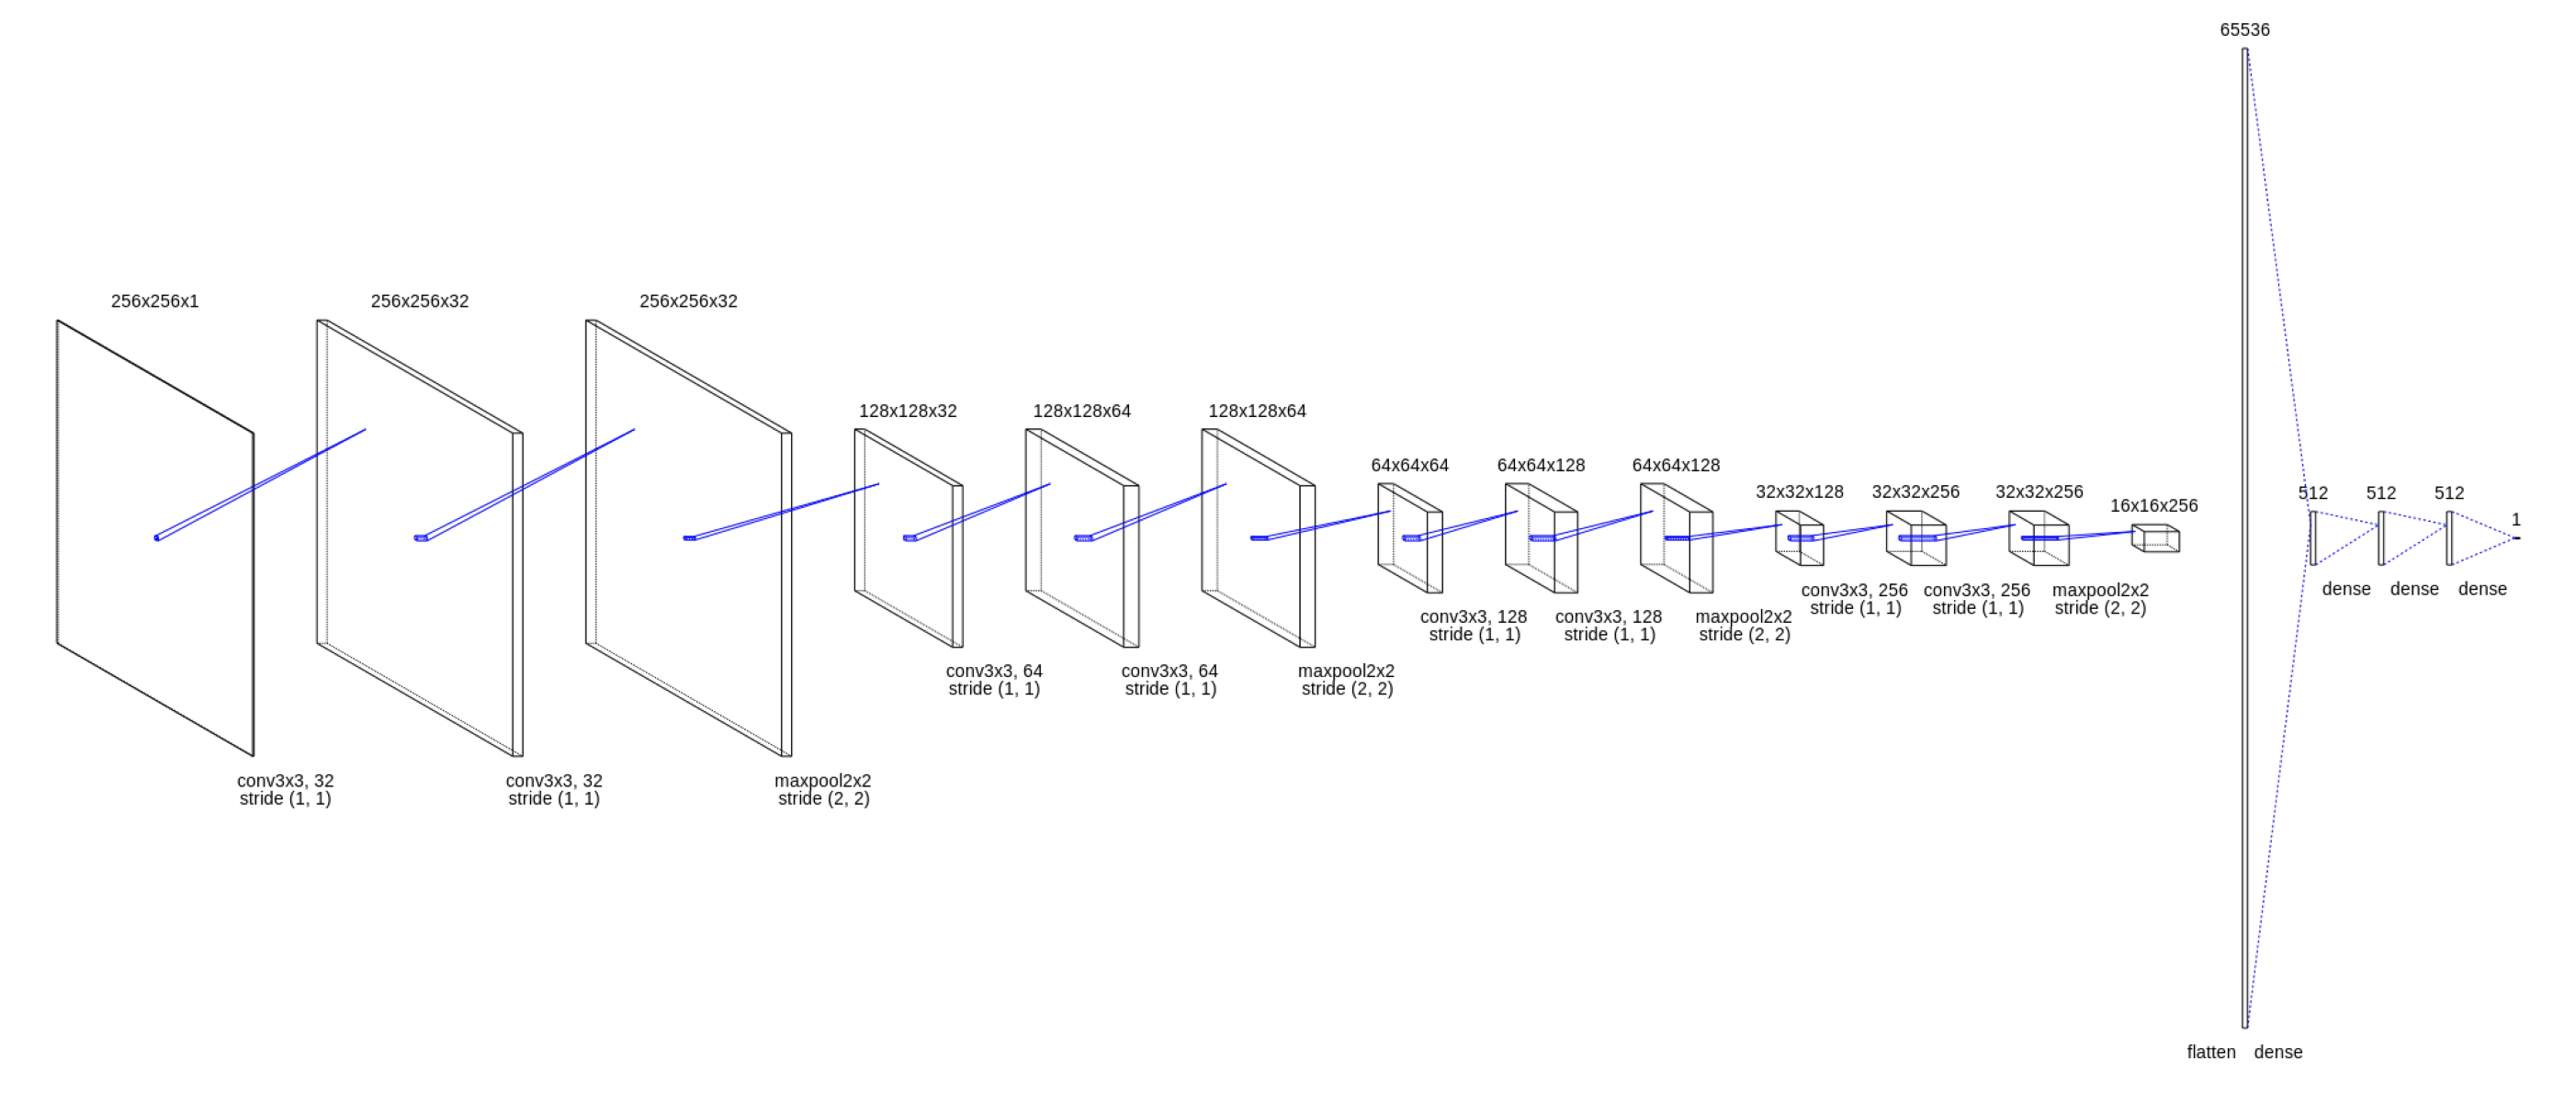

In [19]:
import sys
sys.path.append('/kaggle/input/convnetdrawer')
import convnet_drawer as cd
from cairosvg import svg2png
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

draw_model = cd.Model(input_shape=(256, 256, 1))
draw_model.add(cd.Conv2D(32, (3, 3), padding = 'same'))
draw_model.add(cd.Conv2D(32, (3, 3), padding = 'same'))
draw_model.add(cd.MaxPooling2D((2, 2)))
draw_model.add(cd.Conv2D(64, (3, 3), padding = 'same'))
draw_model.add(cd.Conv2D(64, (3, 3), padding = 'same'))
draw_model.add(cd.MaxPooling2D((2, 2)))
draw_model.add(cd.Conv2D(128, (3, 3), padding = 'same'))
draw_model.add(cd.Conv2D(128, (3, 3), padding = 'same'))
draw_model.add(cd.MaxPooling2D((2, 2)))
draw_model.add(cd.Conv2D(256, (3, 3), padding = 'same'))
draw_model.add(cd.Conv2D(256, (3, 3), padding = 'same'))
draw_model.add(cd.MaxPooling2D((2, 2)))
draw_model.add(cd.Flatten())
draw_model.add(cd.Dense(512))
draw_model.add(cd.Dense(512))
draw_model.add(cd.Dense(512))
draw_model.add(cd.Dense(1))

draw_model.save_fig("cnn_model.svg")
svg2png(url="cnn_model.svg", write_to="cnn_model.png")

img=mpimg.imread('cnn_model.png')
plt.figure(figsize = (50, 50))
plt.axis('off')
imgplot = plt.imshow(img)

del draw_model, img, imgplot

## Data Augmentation

In [20]:
batch_size = 32

train_gen = ImageDataGenerator(rotation_range = 10,
                               horizontal_flip = True,
                               width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               rescale = 1.,
                               zoom_range = 0.2,
                               fill_mode = 'nearest',
                               cval = 0)

train_generator_NN = train_gen.flow(x_train, y_train, batch_size)
train_generator_CNN = train_gen.flow(x_train, y_train, batch_size)

steps_per_epoch = x_train.shape[0] // batch_size

checkpoint_NN = ModelCheckpoint('model_NN.h5', 
                                monitor = 'val_loss', 
                                verbose = 0, 
                                save_best_only = True, 
                                mode = 'auto')

checkpoint_CNN = ModelCheckpoint('model_CNN.h5', 
                                 monitor = 'val_loss', 
                                 verbose = 0, 
                                 save_best_only = True, 
                                 mode = 'auto')


## Treinamento dos Modelos

In [21]:
epochs = 100

history_NN = model_NN.fit(train_generator_NN, 
                          validation_data = (x_test, y_test), 
                          steps_per_epoch = steps_per_epoch, 
                          epochs = epochs,
                          callbacks = [checkpoint_NN],
                          verbose = 2)

history_CNN = model_CNN.fit(train_generator_CNN, 
                            validation_data = (x_test, y_test), 
                            steps_per_epoch = steps_per_epoch, 
                            epochs = epochs,
                            callbacks = [checkpoint_CNN],
                            verbose = 2)

Train for 110 steps, validate on 882 samples
Epoch 1/100
110/110 - 18s - loss: 0.7058 - accuracy: 0.5716 - val_loss: 0.5879 - val_accuracy: 0.7302
Epoch 2/100
110/110 - 16s - loss: 0.6096 - accuracy: 0.6655 - val_loss: 0.4979 - val_accuracy: 0.7653
Epoch 3/100
110/110 - 15s - loss: 0.5554 - accuracy: 0.6890 - val_loss: 0.5676 - val_accuracy: 0.6315
Epoch 4/100
110/110 - 17s - loss: 0.5307 - accuracy: 0.7159 - val_loss: 0.4954 - val_accuracy: 0.7302
Epoch 5/100
110/110 - 16s - loss: 0.5041 - accuracy: 0.7348 - val_loss: 0.4241 - val_accuracy: 0.8027
Epoch 6/100
110/110 - 16s - loss: 0.4888 - accuracy: 0.7540 - val_loss: 0.4122 - val_accuracy: 0.8061
Epoch 7/100
110/110 - 16s - loss: 0.4774 - accuracy: 0.7617 - val_loss: 0.3380 - val_accuracy: 0.8435
Epoch 8/100
110/110 - 17s - loss: 0.4620 - accuracy: 0.7798 - val_loss: 0.4326 - val_accuracy: 0.7630
Epoch 9/100
110/110 - 16s - loss: 0.4515 - accuracy: 0.7841 - val_loss: 0.3317 - val_accuracy: 0.8730
Epoch 10/100
110/110 - 16s - loss: 0.

## Performance do Modelo

In [22]:
model_NN = tf.keras.models.load_model('model_NN.h5')
model_CNN = tf.keras.models.load_model('model_CNN.h5')

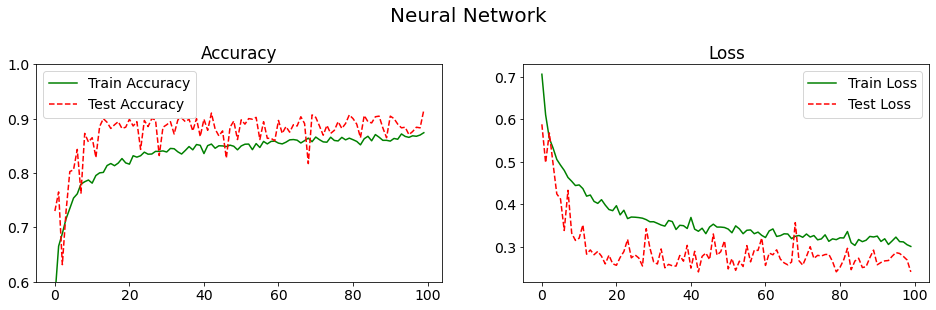

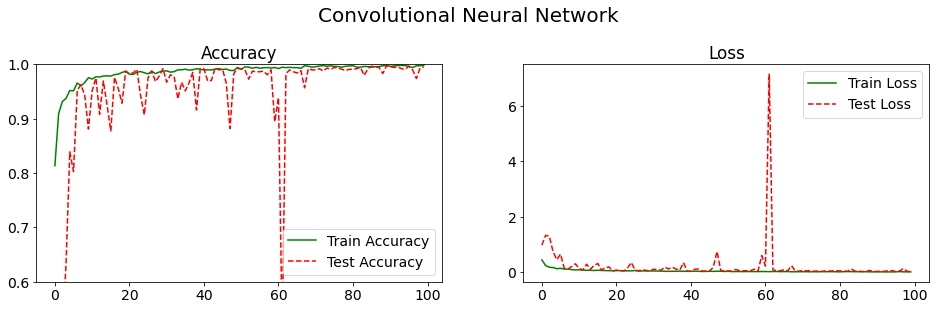

In [23]:
def plot_accuracy_hist(model_history, fig_tittle):

    plt.rcParams.update({'font.size': 14})

    fig = plt.figure(figsize = (16, 4))
    columns = 2
    rows = 1

    fig.suptitle(fig_tittle, fontsize = 20, y = 1.08)
    fig.add_subplot(rows, columns, 1)

    plt.title('Accuracy')
    plt.ylim(0.6, 1)
    
    plt.plot(model_history.history['accuracy'], 
             color='green', 
             label = 'Train Accuracy')

    plt.plot(model_history.history['val_accuracy'], 
             color='red', 
             label = 'Test Accuracy', 
             linestyle='dashed')

    plt.legend()

    fig.add_subplot(rows, columns, 2)

    plt.title('Loss')
    plt.plot(model_history.history['loss'], 
             color='green', 
             label = 'Train Loss')

    plt.plot(model_history.history['val_loss'], 
             color='red', 
             label = 'Test Loss', 
             linestyle='dashed')

    plt.legend()

    plt.show()
    
plot_accuracy_hist(history_NN, 'Neural Network')
plot_accuracy_hist(history_CNN, 'Convolutional Neural Network')

### Confusion Matrix

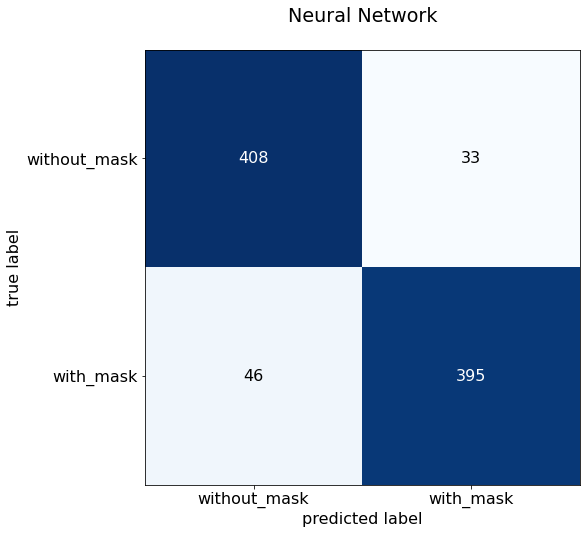

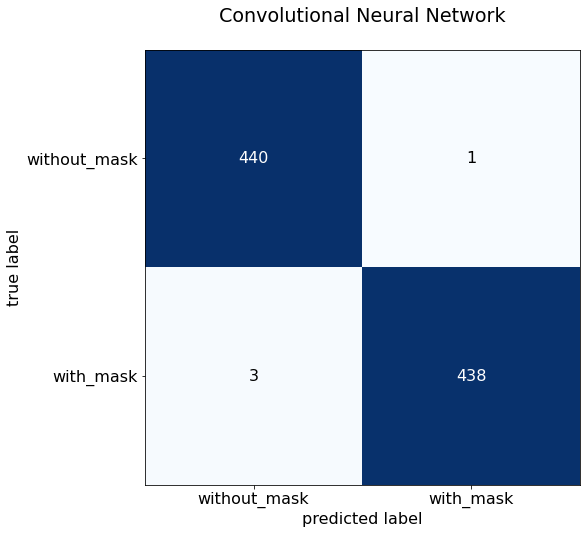

In [24]:
plt.rcParams.update({'font.size': 16})

def plot_confusion_mtx(model, x_test, plot_tittle):
    pred_prob = model.predict(x_test, batch_size = 8)
    pred = np.where(pred_prob > 0.5, 1,0)

    CM = confusion_matrix(y_test, pred)

    plot_confusion_matrix(conf_mat = CM, figsize = (16, 8))
    plt.title(plot_tittle)
    plt.xticks(range(2), labels)
    plt.yticks(range(2), labels)

    plt.show()

plot_confusion_mtx(model_NN, x_test, 'Neural Network')
plot_confusion_mtx(model_CNN, x_test, 'Convolutional Neural Network')

### Receiver Operating Characteristic

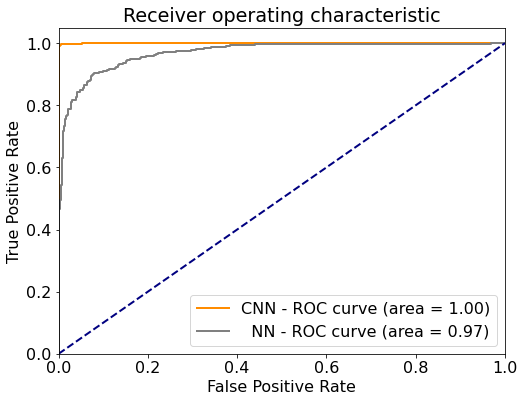

Classification Report - Neural Network
              precision    recall  f1-score   support

           0       0.90      0.93      0.91       441
           1       0.92      0.90      0.91       441

    accuracy                           0.91       882
   macro avg       0.91      0.91      0.91       882
weighted avg       0.91      0.91      0.91       882


Classification Report - Convolutional Neural Network
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       441
           1       1.00      0.99      1.00       441

    accuracy                           1.00       882
   macro avg       1.00      1.00      1.00       882
weighted avg       1.00      1.00      1.00       882



In [25]:
pred_prob_NN  = model_NN.predict(x_test, batch_size = 8)
pred_prob_CNN = model_CNN.predict(x_test, batch_size = 8)

pred_NN  = np.where(pred_prob_NN > 0.5, 1,0)
pred_CNN = np.where(pred_prob_CNN > 0.5, 1,0)

NN_fpr, NN_tpr, _ = roc_curve(y_test, pred_prob_NN)
NN_roc_auc = auc(NN_fpr, NN_tpr)

CNN_fpr, CNN_tpr, _ = roc_curve(y_test, pred_prob_CNN)
CNN_roc_auc = auc(CNN_fpr, CNN_tpr)

plt.rcParams.update({'font.size': 16})

fig = plt.figure(figsize = (8, 6))

lw = 2
plt.plot(CNN_fpr,
         CNN_tpr, 
         color = 'darkorange',
         lw = lw, 
         label = 'CNN - ROC curve (area = %0.2f)' % CNN_roc_auc)

plt.plot(NN_fpr,
         NN_tpr, 
         color = 'grey',
         lw = lw, 
         label = '  NN - ROC curve (area = %0.2f)' % NN_roc_auc)

plt.plot([0, 1], [0, 1], 
         color = 'navy', 
         lw = lw, 
         linestyle = '--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Receiver operating characteristic')
plt.legend(loc = "lower right")

plt.show()

print('Classification Report - Neural Network')
print(classification_report(y_test, pred_NN))

print('\nClassification Report - Convolutional Neural Network')
print(classification_report(y_test, pred_CNN))